In [12]:
import modules.dataset_clouds as dataset_clouds
import image_dehazer
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import config
import os

# Clouds Dataloader

In [24]:
def get_cloud_loader():
    train_transform = A.Compose([
        # A.HorizontalFlip(p=0.5),
        # A.OneOf([
        #     A.RandomBrightnessContrast(p=0.2),
        #     A.HueSaturationValue(hue_shift_limit=10, p=0.2),
        #     A.Blur(blur_limit=(17,17), p=0.3),
        #     A.CLAHE(clip_limit=2.0, p=0.2),
        #     A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.1),
        # ], p=0.9),
        # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.3),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        # A.Resize(640, 640, p=1),
        ToTensorV2(p=1),
        ]
    )
    
    print("\n====================\nTrain CLOUDS dataset")
    train_clouds_ds = dataset_clouds.Clouds(
        img_h=config.IMG_H, 
        img_w=config.IMG_W, 
        img_dir=config.CLOUDS_IMG_DIR, 
        num_classes=config.NUM_CLASSES,
        ds_len=config.DS_LEN,
        transform=train_transform)
    print(f'\nTrain CLOUDS dataset len: {len(train_clouds_ds)}')
  
    train_loader = DataLoader(
        dataset=train_clouds_ds,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=True)
    
    return train_loader

In [25]:
clouds_loader = get_cloud_loader()


Train CLOUDS dataset
Clouds Dataset Removed wrong images: 0

Train CLOUDS dataset len: 4043


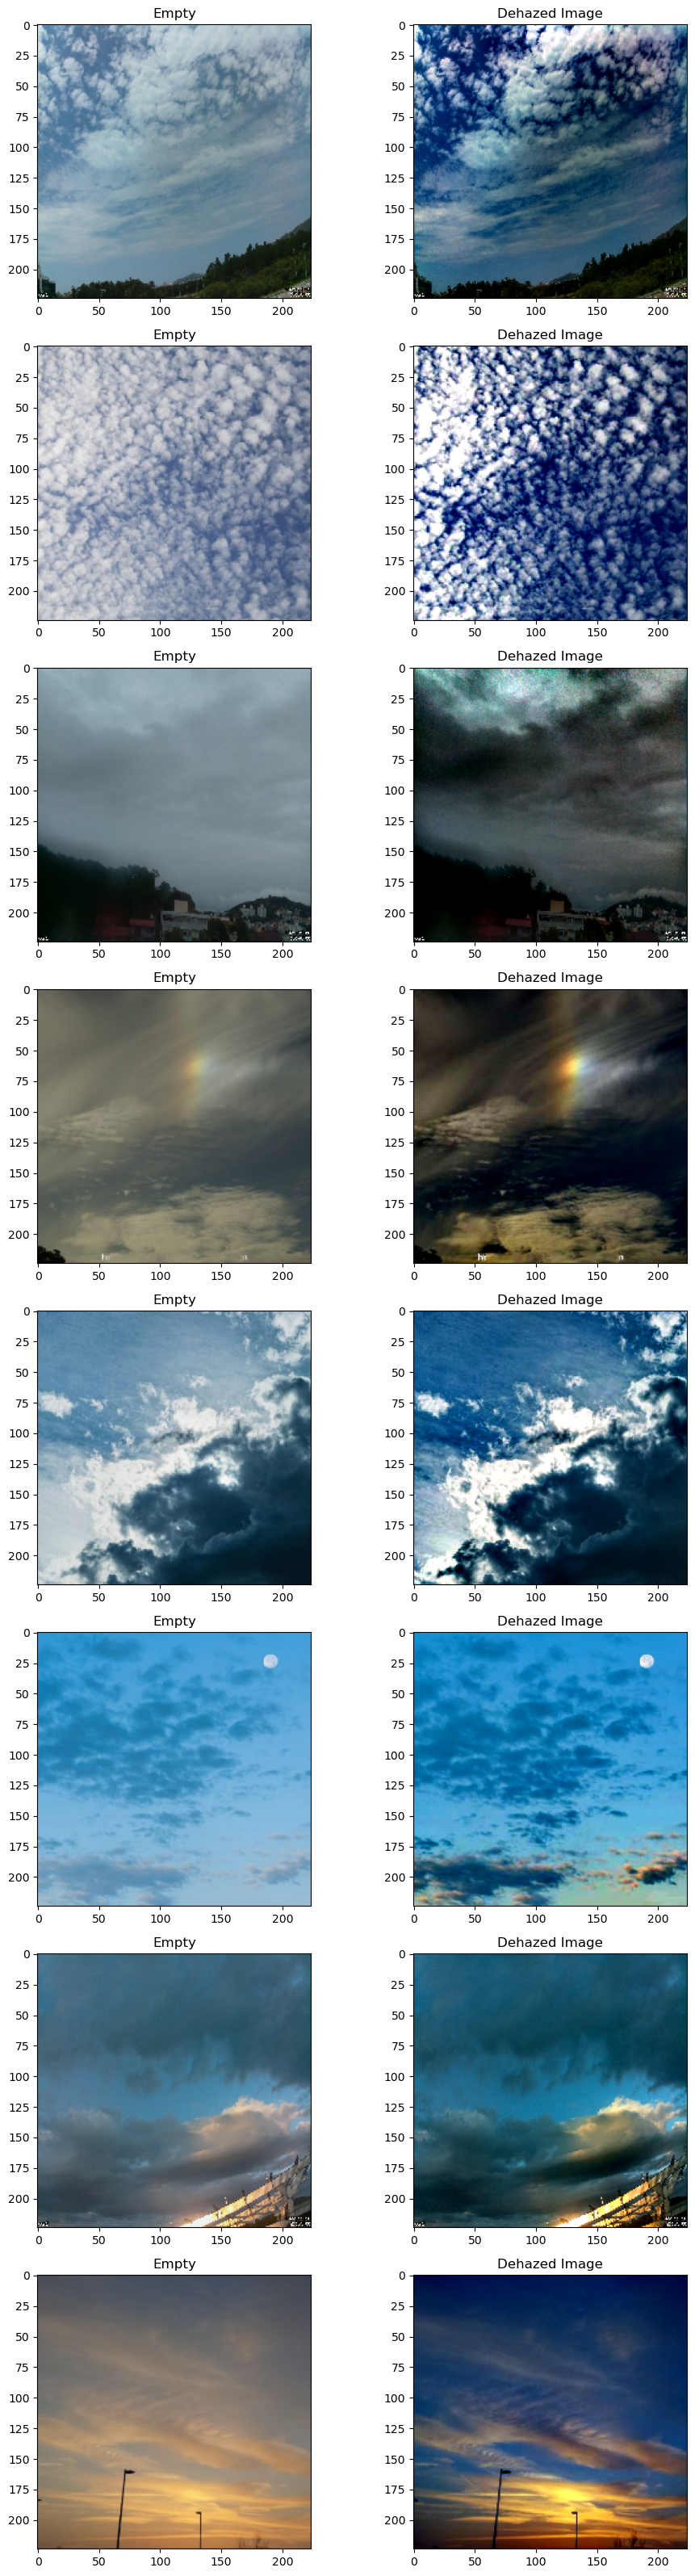

In [26]:
rows = 8
cols = 2
rows_x_cols = rows*cols
half_rows_x_cols = int(rows_x_cols / 2)
plt.subplots(rows, cols, figsize=(10, 32))

for i, (img, label) in zip(range(half_rows_x_cols), clouds_loader):  
    
    # Original Image
    plt.subplot(rows, cols, 2*i+1)
    plt.imshow(img[i].permute(1, 2, 0))
    title = ""
    if label[i][0] == 1 and label[i][1] == 1:
        title += "Smoke and Fire"
    elif label[i][0] == 1 and label[i][1] == 0:
        title += "Only Smoke"
    elif label[i][0] == 0 and label[i][1] == 1:
        title += "Only Fire"
    else:
        title += "Empty"
    plt.title(title)
    
    # Dehazed Image
    hazed_img = img[i]
    hazed_img = hazed_img.permute(1, 2, 0).clone().detach().numpy()
    hazed_img = (hazed_img * 255).astype(np.uint8)
    dehazed_img, _ = image_dehazer.remove_haze(hazed_img, showHazeTransmissionMap=False)	
    plt.subplot(rows, cols, 2*i+2)
    plt.imshow(dehazed_img)
    title = "Dehazed Image"
    plt.title(title)

    if (i == (half_rows_x_cols-1)):
        break
plt.tight_layout()
plt.show()

In [27]:
img_dir = '../../../uav/datasets/clouds/images/'
clouds_list = sorted([img_dir + fname for fname in os.listdir(img_dir) if not fname.startswith('.')])

test_img_fname = clouds_list[0]

test_img = cv2.imread(test_img_fname)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img, (224,224), interpolation = cv2.INTER_AREA)

In [29]:
%%time
HazeCorrectedImg, HazeMap = image_dehazer.remove_haze(test_img, showHazeTransmissionMap=False)	

CPU times: user 57.8 ms, sys: 3.77 ms, total: 61.6 ms
Wall time: 60.9 ms


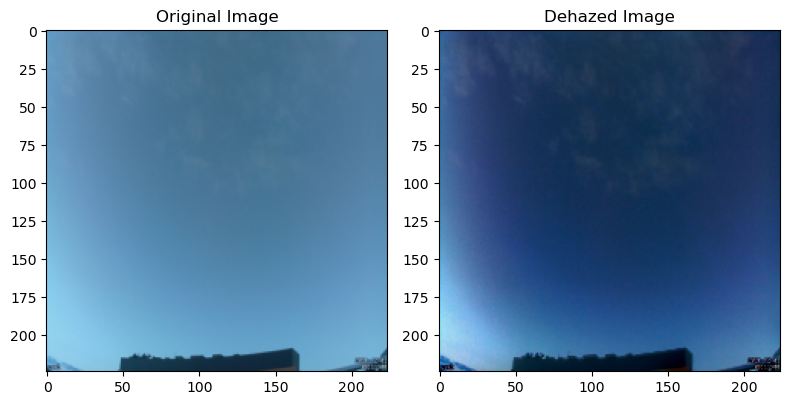

In [33]:
plt.subplots(1, 2, figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(HazeCorrectedImg)
plt.title("Dehazed Image")

plt.tight_layout()
plt.show()